In [1]:
!pip install PySpark
!pip install sparkxgb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for PySpark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=e40ab7eaa28e830cef1551333c9da1ac96a97ae2f3152d703a4d5175f4a83e0b
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built PySpark
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 23.7 MB/s eta 0:00:00
  Created wheel for sparkxgb: filename=sparkxgb-0.1-py3-none-any.whl size=5629 sha256=0e138331408ea9cd7fb929fc52dc859b79378f5ff131b937aeab3fb284b3a6f6
  Stored in directory: /root/.cache/pip/wheels/b7/0c/a1/786408e13056fabeb8a72134e101b1e142fc95905c7b0e2a71
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=

In [2]:
## import libraries and initialize spark session
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, desc, approx_count_distinct, countDistinct,log, sqrt
from pyspark.sql import functions as F

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime
import plotly.figure_factory as ff
import plotly.offline as pyo

In [3]:
#initialize spark session
spark = SparkSession.builder \
    .appName("Data Exploration with PySpark") \
    .getOrCreate()

In [4]:
##Load Data
data_train = "/content/train.csv"
data_testA = "/content/testA.csv"

data_train = spark.read.csv(data_train, header=True, inferSchema=True)
data_testA = spark.read.csv(data_testA, header=True, inferSchema=True)

In [5]:
## Data Preprocessing

#check training dataset structure
data_train.printSchema()
data_train.show(5)

#check the size
print("Train data shape:",(data_train.count(),len(data_train.columns)))
print("TestA data shape:",(data_testA.count(),len(data_testA.columns)))

data_train.describe().show()


root
 |-- id: integer (nullable = true)
 |-- loanAmnt: double (nullable = true)
 |-- term: integer (nullable = true)
 |-- interestRate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- subGrade: string (nullable = true)
 |-- employmentTitle: double (nullable = true)
 |-- employmentLength: string (nullable = true)
 |-- homeOwnership: integer (nullable = true)
 |-- annualIncome: double (nullable = true)
 |-- verificationStatus: integer (nullable = true)
 |-- issueDate: string (nullable = true)
 |-- isDefault: integer (nullable = true)
 |-- purpose: integer (nullable = true)
 |-- postCode: double (nullable = true)
 |-- regionCode: integer (nullable = true)
 |-- dti: double (nullable = true)
 |-- delinquency_2years: double (nullable = true)
 |-- ficoRangeLow: double (nullable = true)
 |-- ficoRangeHigh: double (nullable = true)
 |-- openAcc: double (nullable = true)
 |-- pubRec: double (nullable = true)
 |-- pubRecBankruptcies: d

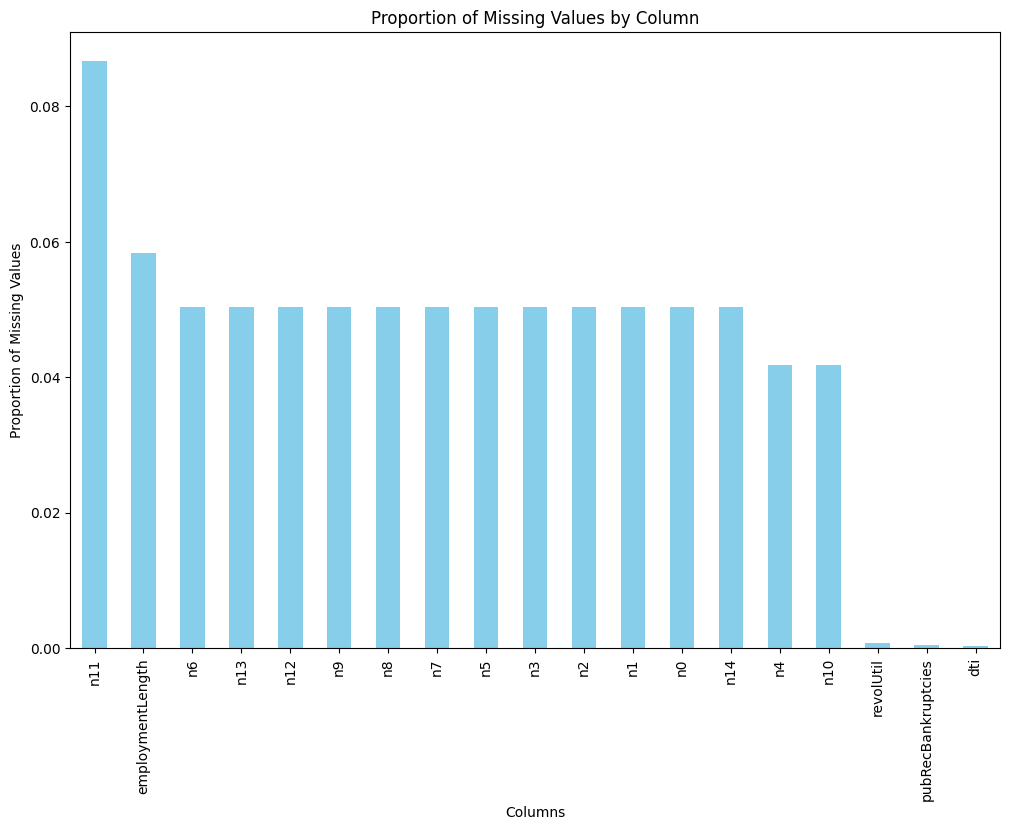

In [6]:
# visualize the NAN
# caclulate the missing ration
def calculate_missing_ratio(df):
    total_count = df.count()
    missing_ratio = df.select([((count(when(col(c).isNull(), c)) / total_count).alias(c)) for c in df.columns])
    return missing_ratio

# get the proportion of missing values
missing_ratio_df = calculate_missing_ratio(data_train)

# transform into pandas dataframe
missing_ratio_pd = missing_ratio_df.toPandas()
missing_ratio_pd = missing_ratio_pd.transpose()
missing_ratio_pd.columns = ['missing_ratio']
missing_ratio_pd = missing_ratio_pd[missing_ratio_pd['missing_ratio'] > 0]
missing_ratio_pd.sort_values(by='missing_ratio', ascending=False, inplace=True)

# plot a bar chart
plt.figure(figsize=(12, 8))
missing_ratio_pd['missing_ratio'].plot(kind='bar', color='skyblue')
plt.title('Proportion of Missing Values by Column')
plt.xlabel('Columns')
plt.ylabel('Proportion of Missing Values')
plt.show()

In [7]:
# Numeric and Object Type Characteristics
numeric_features = [t[0] for t in data_train.dtypes if t[1] == 'int' or t[1] == 'double']
object_features = [t[0] for t in data_train.dtypes if t[1] == 'string']

print("Numeric Features:", numeric_features)
print("Object Features:", object_features)

Numeric Features: ['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'employmentTitle', 'homeOwnership', 'annualIncome', 'verificationStatus', 'isDefault', 'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc', 'initialListStatus', 'applicationType', 'title', 'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'n13', 'n14']
Object Features: ['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']


In [8]:
data_train.select('grade').show(5)

+-----+
|grade|
+-----+
|    E|
|    D|
|    D|
|    A|
|    C|
+-----+
only showing top 5 rows



In [9]:
## numeric and object
def get_numerical_serial_fea(data, feas):
    numerical_serial_fea = []
    numerical_noserial_fea = []

    for fea in feas:
        unique_count = data.agg(approx_count_distinct(col(fea)).alias('distinct_count')).collect()[0]['distinct_count']

        if unique_count <= 10:
            numerical_noserial_fea.append(fea)
        else:
            numerical_serial_fea.append(fea)

    return numerical_serial_fea, numerical_noserial_fea

try:
    numerical_serial_fea, numerical_noserial_fea = get_numerical_serial_fea(data_train, numeric_features)
    print("Serial (Continuous) Numerical Features:", numerical_serial_fea)
    print("NoSerial (Discrete) Numerical Features:", numerical_noserial_fea)
except Exception as e:
    print("An error occurred:", e)

Serial (Continuous) Numerical Features: ['id', 'loanAmnt', 'interestRate', 'installment', 'employmentTitle', 'annualIncome', 'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'revolBal', 'revolUtil', 'totalAcc', 'title', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n13', 'n14']
NoSerial (Discrete) Numerical Features: ['term', 'homeOwnership', 'verificationStatus', 'isDefault', 'pubRecBankruptcies', 'initialListStatus', 'applicationType', 'policyCode', 'n11', 'n12']


In [10]:
# count the value
term_counts = data_train.groupBy("term").count()
term_counts.show()

homeOwnership_counts = data_train.groupBy("homeOwnership").count()
homeOwnership_counts.show()

verificationStatus_counts = data_train.groupBy("verificationStatus").count()
verificationStatus_counts.show()

initialListStatus_counts = data_train.groupBy("initialListStatus").count()
initialListStatus_counts.show()

applicationType_counts = data_train.groupBy("applicationType").count()
applicationType_counts.show()

policyCode_counts = data_train.groupBy("policyCode").count()
policyCode_counts.show()

n11_counts = data_train.groupBy("n11").count()
n11_counts.show()

n12_counts = data_train.groupBy("n12").count()
n12_counts.show()

+----+------+
|term| count|
+----+------+
|   3|149332|
|   5| 47735|
+----+------+

+-------------+-----+
|homeOwnership|count|
+-------------+-----+
|            1|78211|
|            3|   47|
|            5|   23|
|            4|   13|
|            2|21372|
|            0|97401|
+-------------+-----+

+------------------+-----+
|verificationStatus|count|
+------------------+-----+
|                 1|76501|
|                 2|60859|
|                 0|59707|
+------------------+-----+

+-----------------+------+
|initialListStatus| count|
+-----------------+------+
|                1| 82028|
|                0|115039|
+-----------------+------+

+---------------+------+
|applicationType| count|
+---------------+------+
|              1|  3720|
|              0|193347|
+---------------+------+

+----------+------+
|policyCode| count|
+----------+------+
|       1.0|197067|
+----------+------+

+----+------+
| n11| count|
+----+------+
| 0.0|179833|
|null| 17079|
| 1.0|   148|
| 4.0

In [11]:
## check the loanAmnt
from pyspark.sql.functions import col, log
# caculate basisc statistics
stats = data_train.select(log(col("loanAmnt")).alias("loanAmnt_log")).summary("count","mean","stddev","min","25%","50%","75%","max")
#pandas dataframe
stats_pd = stats.toPandas()
print(stats_pd)

  summary        loanAmnt_log
0   count              197067
1    mean   9.367007540081174
2  stddev  0.6960061169730382
3     min   6.620073206530356
4     25%   8.980927207648378
5     50%   9.392661928770137
6     75%   9.903487552536127
7     max  10.596634733096073


In [12]:
# calculate the object values
grade_counts = data_train.groupBy("grade").count().orderBy("grade")
subgrade_counts = data_train.groupBy("subGrade").count().orderBy("subGrade")
employment_length_counts = data_train.groupBy("employmentLength").count().orderBy("employmentLength")
issue_date_counts = data_train.groupBy("issueDate").count().orderBy("issueDate")
earliesCreditLine_counts = data_train.groupBy("earliesCreditLine").count().orderBy("earliesCreditLine")
isDefault_counts = data_train.groupBy("isDefault").count().orderBy("isDefault")

grade_counts.show()
subgrade_counts.show()
employment_length_counts.show()
issue_date_counts.show()
earliesCreditLine_counts.show()
isDefault_counts.show()

+-----+-----+
|grade|count|
+-----+-----+
|    A|34246|
|    B|57697|
|    C|56010|
|    D|29310|
|    E|13714|
|    F| 4727|
|    G| 1363|
+-----+-----+

+--------+-----+
|subGrade|count|
+--------+-----+
|      A1| 6322|
|      A2| 5565|
|      A3| 5484|
|      A4| 7612|
|      A5| 9263|
|      B1|10307|
|      B2|10882|
|      B3|12011|
|      B4|12315|
|      B5|12182|
|      C1|12654|
|      C2|11576|
|      C3|10981|
|      C4|10889|
|      C5| 9910|
|      D1| 7533|
|      D2| 6505|
|      D3| 5769|
|      D4| 5183|
|      D5| 4320|
+--------+-----+
only showing top 20 rows

+----------------+-----+
|employmentLength|count|
+----------------+-----+
|            null|11502|
|          1 year|13134|
|       10+ years|64724|
|         2 years|17763|
|         3 years|15703|
|         4 years|11930|
|         5 years|12249|
|         6 years| 9205|
|         7 years| 8705|
|         8 years| 8829|
|         9 years| 7494|
|        < 1 year|15829|
+----------------+-----+

+---------

In [13]:
## Data Pre-Processing
# NAN values
from pyspark.sql.functions import col, sum as spark_sum, isnan, when, count
missing_data = data_train.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in data_train.columns]
)
missing_data.show()

+---+--------+----+------------+-----------+-----+--------+---------------+----------------+-------------+------------+------------------+---------+---------+-------+--------+----------+---+------------------+------------+-------------+-------+------+------------------+--------+---------+--------+-----------------+---------------+-----------------+-----+----------+----+----+----+----+----+----+----+----+----+----+----+-----+----+----+----+
| id|loanAmnt|term|interestRate|installment|grade|subGrade|employmentTitle|employmentLength|homeOwnership|annualIncome|verificationStatus|issueDate|isDefault|purpose|postCode|regionCode|dti|delinquency_2years|ficoRangeLow|ficoRangeHigh|openAcc|pubRec|pubRecBankruptcies|revolBal|revolUtil|totalAcc|initialListStatus|applicationType|earliesCreditLine|title|policyCode|  n0|  n1|  n2|  n3|  n4|  n5|  n6|  n7|  n8|  n9| n10|  n11| n12| n13| n14|
+---+--------+----+------------+-----------+-----+--------+---------------+----------------+-------------+------

In [14]:
##fill the NAN
from pyspark.sql.functions import col, lit, when

# Add a default 'isDefault' column to the test set for structural consistency
data_testA = data_testA.withColumn('isDefault', lit(-1))

# Merge the datasets
combined_data = data_train.unionByName(data_testA)

# Fill in numeric features
for col in numeric_features:
    if col in combined_data.columns:
        median_value = combined_data.approxQuantile(col, [0.5], 0.001)[0]
        combined_data = combined_data.na.fill({col: median_value})

# Fill in object features
for col in object_features:
    if col in combined_data.columns:
        mode_value = combined_data.groupBy(col).count().orderBy('count', ascending=False).first()[0]
        combined_data = combined_data.na.fill({col: mode_value})

# Separate the datasets
data_train = combined_data.where(combined_data['isDefault'] != -1)
data_test_a = combined_data.where(combined_data['isDefault'] == -1).drop('isDefault')

In [15]:
# recaculate the NAN
from pyspark.sql.functions import col, count, when

null_counts = data_train.select([(count(when(col(c).isNull(), c))).alias(c) for c in data_train.columns])

null_counts.show()


+---+--------+----+------------+-----------+-----+--------+---------------+----------------+-------------+------------+------------------+---------+---------+-------+--------+----------+---+------------------+------------+-------------+-------+------+------------------+--------+---------+--------+-----------------+---------------+-----------------+-----+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| id|loanAmnt|term|interestRate|installment|grade|subGrade|employmentTitle|employmentLength|homeOwnership|annualIncome|verificationStatus|issueDate|isDefault|purpose|postCode|regionCode|dti|delinquency_2years|ficoRangeLow|ficoRangeHigh|openAcc|pubRec|pubRecBankruptcies|revolBal|revolUtil|totalAcc|initialListStatus|applicationType|earliesCreditLine|title|policyCode| n0| n1| n2| n3| n4| n5| n6| n7| n8| n9|n10|n11|n12|n13|n14|
+---+--------+----+------------+-----------+-----+--------+---------------+----------------+-------------+------------+------------------+------

In [16]:
## employmentlength pre-pro
from pyspark.sql.functions import col, to_date, datediff, lit

# Define the start date
startdate = lit("2007-06-01")

for data in [data_train, data_testA]:
    # Convert 'issueDate' from string to date format
    data = data.withColumn('issueDate', to_date(col('issueDate'), 'yyyy-MM-dd'))
    # Create a new column 'issueDateDT' as the difference in days from the start date
    data = data.withColumn('issueDateDT', datediff(col('issueDate'), startdate))

employment_length_counts = data_train.groupBy('employmentLength').count().orderBy('employmentLength')

# Show the result
employment_length_counts.show()
data_train.select('issueDate').show(5)

+----------------+-----+
|employmentLength|count|
+----------------+-----+
|          1 year|13134|
|       10+ years|76226|
|         2 years|17763|
|         3 years|15703|
|         4 years|11930|
|         5 years|12249|
|         6 years| 9205|
|         7 years| 8705|
|         8 years| 8829|
|         9 years| 7494|
|        < 1 year|15829|
+----------------+-----+

+----------+
| issueDate|
+----------+
|2014-07-01|
|2012-08-01|
|2015-10-01|
|2015-08-01|
|2016-03-01|
+----------+
only showing top 5 rows



In [17]:
## transform employment into float
from pyspark.sql.functions import udf, col, when
from pyspark.sql.types import FloatType

# Define a UDF to convert employment length strings to float values
def employment_length_to_float(s):
    if s is None:
        return None
    elif s == '< 1 year':
        return 0.0
    else:
        return float(s.split()[0])

employment_length_to_float_udf = udf(employment_length_to_float, FloatType())

# Update and replace '10+ years' with '10 years' and '< 1 year' with '0 years'
data_train = data_train.withColumn('employmentLength',
                                   when(col('employmentLength') == '10+ years', '10 years')
                                   .when(col('employmentLength') == '< 1 year', '0 years')
                                   .otherwise(col('employmentLength')))

data_train = data_train.withColumn('employmentLength', employment_length_to_float_udf(col('employmentLength')))

data_testA = data_testA.withColumn('employmentLength',
                                   when(col('employmentLength') == '10+ years', '10 years')
                                   .when(col('employmentLength') == '< 1 year', '0 years')
                                   .otherwise(col('employmentLength')))

data_testA = data_testA.withColumn('employmentLength', employment_length_to_float_udf(col('employmentLength')))

# Show the results after conversion
data_train.select('employmentLength').show()


+----------------+
|employmentLength|
+----------------+
|             2.0|
|             5.0|
|             8.0|
|            10.0|
|            10.0|
|             7.0|
|             9.0|
|             1.0|
|             5.0|
|            10.0|
|            10.0|
|             3.0|
|             2.0|
|            10.0|
|             2.0|
|             2.0|
|             9.0|
|             0.0|
|            10.0|
|             9.0|
+----------------+
only showing top 20 rows



In [18]:
## earliescredit trans
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# Define a UDF to extract the year from the 'earliesCreditLine' string
def extract_year(credit_line):
    return int(credit_line[-4:])

# Register the UDF
extract_year_udf = udf(extract_year, IntegerType())

# Apply the UDF to the 'earliesCreditLine' column of each DataFrame
for data in [data_train, data_test_a]:
    data = data.withColumn('earliesCreditLine', extract_year_udf(data['earliesCreditLine']))

# Show the results to verify the transformation, displaying only the 'earliesCreditLine' column
data_train.select('earliesCreditLine').show()
data_test_a.select('earliesCreditLine').show()

+-----------------+
|earliesCreditLine|
+-----------------+
|         Aug-2001|
|         May-2002|
|         May-2006|
|         May-1999|
|         Aug-1977|
|         Jul-1998|
|         Oct-2006|
|         Dec-1994|
|         Apr-1994|
|         Jan-1993|
|         Nov-1996|
|         Aug-2007|
|         Feb-2014|
|         Oct-1983|
|         May-2011|
|         Oct-1996|
|         Mar-2002|
|         Jun-1995|
|         Aug-2001|
|         Oct-1999|
+-----------------+
only showing top 20 rows

+-----------------+
|earliesCreditLine|
+-----------------+
|         Nov-1974|
|         Jul-2001|
|         Aug-2006|
|         Jul-2002|
|         Dec-2000|
|         Jul-2000|
|         Jan-1998|
|         Feb-2007|
|         May-2004|
|         Sep-1992|
|         Feb-2007|
|         Dec-2003|
|         Jun-2000|
|         Dec-1998|
|         Jan-1987|
|         Aug-1983|
|         Mar-2006|
|         Mar-2002|
|         Oct-1986|
|         Aug-2005|
+-----------------+
only showing t

In [19]:
from pyspark.sql.functions import when, col
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Convert 'grade' to numeric values
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
for grade, mapping in grade_mapping.items():
    data_train = data_train.withColumn('grade', when(col('grade') == grade, mapping).otherwise(col('grade')))
    data_testA = data_testA.withColumn('grade', when(col('grade') == grade, mapping).otherwise(col('grade')))

# Define categorical columns to be one-hot encoded
categorical_columns = ['subGrade', 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode']
indexed_columns = []  # to store indexed column names
encoded_columns = []  # to store encoded column names

for column in categorical_columns:
    # Index each categorical column before encoding
    indexer = StringIndexer(inputCol=column, outputCol=column + "Index")
    data_train = indexer.fit(data_train).transform(data_train)
    data_testA = indexer.fit(data_testA).transform(data_testA)
    indexed_columns.append(column + "Index")

    # Apply one-hot encoding to the indexed columns
    encoder = OneHotEncoder(inputCols=[column + "Index"], outputCols=[column + "OHE"])
    data_train = encoder.fit(data_train).transform(data_train)
    data_testA = encoder.fit(data_testA).transform(data_testA)
    encoded_columns.append(column + "OHE")

    # Optionally drop original columns if no longer needed
    data_train = data_train.drop(column)
    data_testA = data_testA.drop(column)

# Collect all new feature column names
all_new_features = indexed_columns + encoded_columns + ['grade']

# Show the results for modified features only
data_train.select(all_new_features).show()


+-------------+------------------+-----------------------+------------+---------------+---------------+----------------+---------------------+--------------+---------------+-----+
|subGradeIndex|homeOwnershipIndex|verificationStatusIndex|purposeIndex|regionCodeIndex|    subGradeOHE|homeOwnershipOHE|verificationStatusOHE|    purposeOHE|  regionCodeOHE|grade|
+-------------+------------------+-----------------------+------------+---------------+---------------+----------------+---------------------+--------------+---------------+-----+
|         21.0|               2.0|                    1.0|         6.0|           20.0|(34,[21],[1.0])|   (5,[2],[1.0])|        (2,[1],[1.0])|(13,[6],[1.0])|(50,[20],[1.0])|    5|
|         13.0|               0.0|                    1.0|         0.0|           16.0|(34,[13],[1.0])|   (5,[0],[1.0])|        (2,[1],[1.0])|(13,[0],[1.0])|(50,[16],[1.0])|    4|
|         15.0|               0.0|                    1.0|         0.0|            1.0|(34,[15],[1.0

In [20]:
#schema
data_train.printSchema()

# basic statistic
data_train.describe().show()

# get the number of rows and column
print("rows: ", data_train.count())
print("cols: ", len(data_train.columns))

# check the type
print("dtypes: ", data_train.dtypes)

root
 |-- id: integer (nullable = true)
 |-- loanAmnt: double (nullable = false)
 |-- term: integer (nullable = true)
 |-- interestRate: double (nullable = false)
 |-- installment: double (nullable = false)
 |-- grade: string (nullable = false)
 |-- employmentTitle: double (nullable = false)
 |-- employmentLength: float (nullable = true)
 |-- annualIncome: double (nullable = false)
 |-- issueDate: string (nullable = false)
 |-- isDefault: integer (nullable = true)
 |-- postCode: double (nullable = false)
 |-- dti: double (nullable = false)
 |-- delinquency_2years: double (nullable = false)
 |-- ficoRangeLow: double (nullable = false)
 |-- ficoRangeHigh: double (nullable = false)
 |-- openAcc: double (nullable = false)
 |-- pubRec: double (nullable = false)
 |-- pubRecBankruptcies: double (nullable = false)
 |-- revolBal: double (nullable = false)
 |-- revolUtil: double (nullable = false)
 |-- totalAcc: double (nullable = false)
 |-- initialListStatus: integer (nullable = true)
 |-- app

In [21]:
index_columns = ['subGradeIndex', 'homeOwnershipIndex', 'verificationStatusIndex', 'purposeIndex', 'regionCodeIndex']
ohe_columns = ['subGradeOHE', 'homeOwnershipOHE', 'verificationStatusOHE', 'purposeOHE', 'regionCodeOHE']

# This dataset will use the original categorical features without any indexes or one-hot encoded columns.
data_train1 = data_train.drop(*index_columns, *ohe_columns)

# This dataset keeps only the indexed versions of the categorical variables, removing the one-hot encoded versions.
data_train2 = data_train.drop(*ohe_columns)

# This dataset removes all index columns and retains only the one-hot encoded columns for the models that use them.
data_train3 = data_train.drop(*index_columns)

# Printing the schemas to verify the results
print("Data Train 1 Schema:")
data_train1.printSchema()

print("Data Train 2 Schema:")
data_train2.printSchema()

print("Data Train 3 Schema:")
data_train3.printSchema()


Data Train 1 Schema:
root
 |-- id: integer (nullable = true)
 |-- loanAmnt: double (nullable = false)
 |-- term: integer (nullable = true)
 |-- interestRate: double (nullable = false)
 |-- installment: double (nullable = false)
 |-- grade: string (nullable = false)
 |-- employmentTitle: double (nullable = false)
 |-- employmentLength: float (nullable = true)
 |-- annualIncome: double (nullable = false)
 |-- issueDate: string (nullable = false)
 |-- isDefault: integer (nullable = true)
 |-- postCode: double (nullable = false)
 |-- dti: double (nullable = false)
 |-- delinquency_2years: double (nullable = false)
 |-- ficoRangeLow: double (nullable = false)
 |-- ficoRangeHigh: double (nullable = false)
 |-- openAcc: double (nullable = false)
 |-- pubRec: double (nullable = false)
 |-- pubRecBankruptcies: double (nullable = false)
 |-- revolBal: double (nullable = false)
 |-- revolUtil: double (nullable = false)
 |-- totalAcc: double (nullable = false)
 |-- initialListStatus: integer (null

In [22]:
from pyspark.sql.functions import to_date, datediff, lit, when, col, udf
from pyspark.sql.types import IntegerType
## preprocessing again
startdate = lit("2007-06-01")

data_train1 = data_train1.withColumn('issueDate', to_date(col('issueDate'), 'yyyy-MM-dd'))
data_train1 = data_train1.withColumn('issueDateDT', datediff(col('issueDate'), startdate))

grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
mapping_expr = col("grade")
for grade, value in grade_mapping.items():
    mapping_expr = when(col("grade") == grade, value).otherwise(mapping_expr)
data_train1 = data_train1.withColumn("grade", mapping_expr.cast("integer"))
data_train1.select("grade").show()

def extract_year(credit_line):
    if credit_line is None or len(credit_line) < 4:
        return None
    return int(credit_line[-4:])

extract_year_udf = udf(extract_year, IntegerType())

# delete 'issueDate'
data_train1 = data_train1.drop('issueDate','earliesCreditLine')

# Display the updated DataFrame structure, confirming that the columns have been deleted
data_train1.printSchema()


+-----+
|grade|
+-----+
|    5|
|    4|
|    4|
|    1|
|    3|
|    1|
|    1|
|    3|
|    3|
|    2|
|    2|
|    5|
|    4|
|    2|
|    1|
|    2|
|    4|
|    2|
|    5|
|    5|
+-----+
only showing top 20 rows

root
 |-- id: integer (nullable = true)
 |-- loanAmnt: double (nullable = false)
 |-- term: integer (nullable = true)
 |-- interestRate: double (nullable = false)
 |-- installment: double (nullable = false)
 |-- grade: integer (nullable = true)
 |-- employmentTitle: double (nullable = false)
 |-- employmentLength: float (nullable = true)
 |-- annualIncome: double (nullable = false)
 |-- isDefault: integer (nullable = true)
 |-- postCode: double (nullable = false)
 |-- dti: double (nullable = false)
 |-- delinquency_2years: double (nullable = false)
 |-- ficoRangeLow: double (nullable = false)
 |-- ficoRangeHigh: double (nullable = false)
 |-- openAcc: double (nullable = false)
 |-- pubRec: double (nullable = false)
 |-- pubRecBankruptcies: double (nullable = false)
 |-- r

In [23]:
from pyspark.sql.functions import col

index_columns = ['subGradeIndex', 'homeOwnershipIndex', 'verificationStatusIndex', 'purposeIndex', 'regionCodeIndex']
ohe_columns = ['subGradeOHE', 'homeOwnershipOHE', 'verificationStatusOHE', 'purposeOHE', 'regionCodeOHE']

# Creating data_train2: Only keep Index columns and remove all OHE columns
# Joining with data_train to add Index columns
data_train2 = data_train1.join(data_train.select('id', *index_columns), on='id', how='left')

# Creating data_train3: Remove Index columns and only keep OHE columns
# Joining with data_train to add OHE columns
data_train3 = data_train1.join(data_train.select('id', *ohe_columns), on='id', how='left')

# Printing the schemas to verify the results
print("Data Train 2 Schema:")
data_train2.printSchema()

print("Data Train 3 Schema:")
data_train3.printSchema()


Data Train 2 Schema:
root
 |-- id: integer (nullable = true)
 |-- loanAmnt: double (nullable = false)
 |-- term: integer (nullable = true)
 |-- interestRate: double (nullable = false)
 |-- installment: double (nullable = false)
 |-- grade: integer (nullable = true)
 |-- employmentTitle: double (nullable = false)
 |-- employmentLength: float (nullable = true)
 |-- annualIncome: double (nullable = false)
 |-- isDefault: integer (nullable = true)
 |-- postCode: double (nullable = false)
 |-- dti: double (nullable = false)
 |-- delinquency_2years: double (nullable = false)
 |-- ficoRangeLow: double (nullable = false)
 |-- ficoRangeHigh: double (nullable = false)
 |-- openAcc: double (nullable = false)
 |-- pubRec: double (nullable = false)
 |-- pubRecBankruptcies: double (nullable = false)
 |-- revolBal: double (nullable = false)
 |-- revolUtil: double (nullable = false)
 |-- totalAcc: double (nullable = false)
 |-- initialListStatus: integer (nullable = true)
 |-- applicationType: integer

In [24]:
## convert the OHE into numeric cols
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.ml.linalg import VectorUDT

# Define the UDF to extract elements from the vector
def extract_vector_element(vector, index):
    try:
        return int(vector[index])
    except IndexError:
        return 0  # Return 0 if the index is out of range

# Register the UDF
extract_element_udf = udf(extract_vector_element, IntegerType())

# Define your OHE columns
ohe_columns = ['subGradeOHE', 'homeOwnershipOHE', 'verificationStatusOHE', 'purposeOHE', 'regionCodeOHE']

# Assuming you know the number of categories in each OHE vector
num_categories = {
    'subGradeOHE': 35,
    'homeOwnershipOHE': 6,
    'verificationStatusOHE': 3,
    'purposeOHE': 14,
    'regionCodeOHE': 51
}

# Apply the UDF to each OHE column and expand into multiple columns
for column in ohe_columns:
    categories = num_categories[column]
    for i in range(categories):
        new_col_name = f"{column}_{i}"
        data_train3 = data_train3.withColumn(new_col_name, extract_element_udf(col(column), lit(i)))


In [25]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col

# Define the columns to include in the correlation analysis
numeric_features = [t[0] for t in data_train1.dtypes if t[1] in ['int', 'double', 'float'] and t[0] != 'isDefault']

# Add the target variable 'isDefault'
features = numeric_features + ['isDefault']

# Use VectorAssembler to combine all feature columns into a single vector column
assembler = VectorAssembler(inputCols=features, outputCol="features")
assembled_data = assembler.transform(data_train1)

# Compute the Pearson correlation matrix between all features (including 'isDefault')
correlation_matrix = Correlation.corr(assembled_data, "features", "pearson").head()[0]

# Extract the correlation values for 'isDefault' with all features
correlation_vector = correlation_matrix.toArray()[:, -1]  # Select the last column, correlations with 'isDefault'

# Create a pandas DataFrame for easy viewing
import pandas as pd
correlation_df = pd.DataFrame(correlation_vector[:-1], index=numeric_features, columns=['Correlation with isDefault'])
correlation_df


,Correlation with isDefault
id,-0.002034
loanAmnt,0.065373
term,0.177523
interestRate,0.260505
installment,0.051345
grade,0.263210
employmentTitle,-0.031957
employmentLength,-0.001151
annualIncome,-0.039280
postCode,0.008223


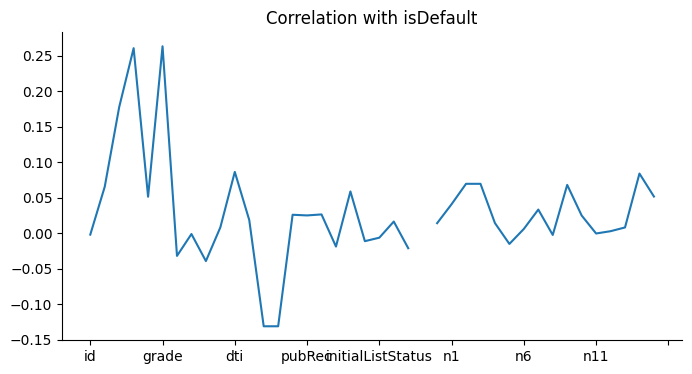

In [26]:
from matplotlib import pyplot as plt
correlation_df['Correlation with isDefault'].plot(kind='line', figsize=(8, 4), title='Correlation with isDefault')
plt.gca().spines[['top', 'right']].set_visible(False)

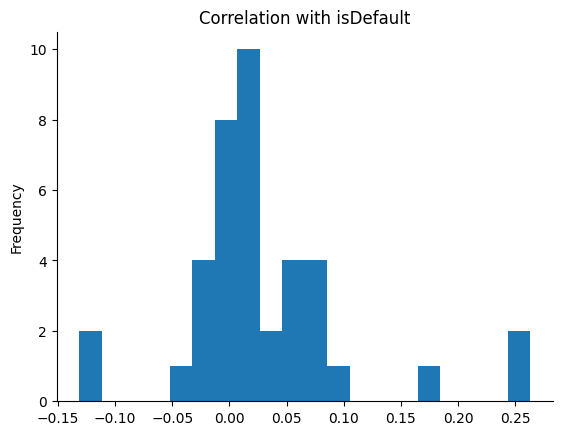

In [27]:
# @title Correlation with isDefault

from matplotlib import pyplot as plt
correlation_df['Correlation with isDefault'].plot(kind='hist', bins=20, title='Correlation with isDefault')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [28]:
print(correlation_vector)

[-2.03430884e-03  6.53730374e-02  1.77522643e-01  2.60505152e-01
  5.13445024e-02  2.63209795e-01 -3.19565731e-02 -1.15051949e-03
 -3.92799908e-02  8.22310508e-03  8.62752227e-02  1.85007964e-02
 -1.31081801e-01 -1.31080534e-01  2.59463928e-02  2.50264778e-02
  2.64271172e-02 -1.88153868e-02  5.87520521e-02 -1.12334336e-02
 -6.31839780e-03  1.63796849e-02 -2.11516970e-02             nan
  1.41017722e-02  4.08281738e-02  6.95338345e-02  6.95338345e-02
  1.42398667e-02 -1.51238011e-02  6.01432257e-03  3.32697421e-02
 -2.49399631e-03  6.80077115e-02  2.49190776e-02 -4.26518609e-04
  2.81498910e-03  8.09355805e-03  8.39906598e-02  5.16318837e-02
  1.00000000e+00]


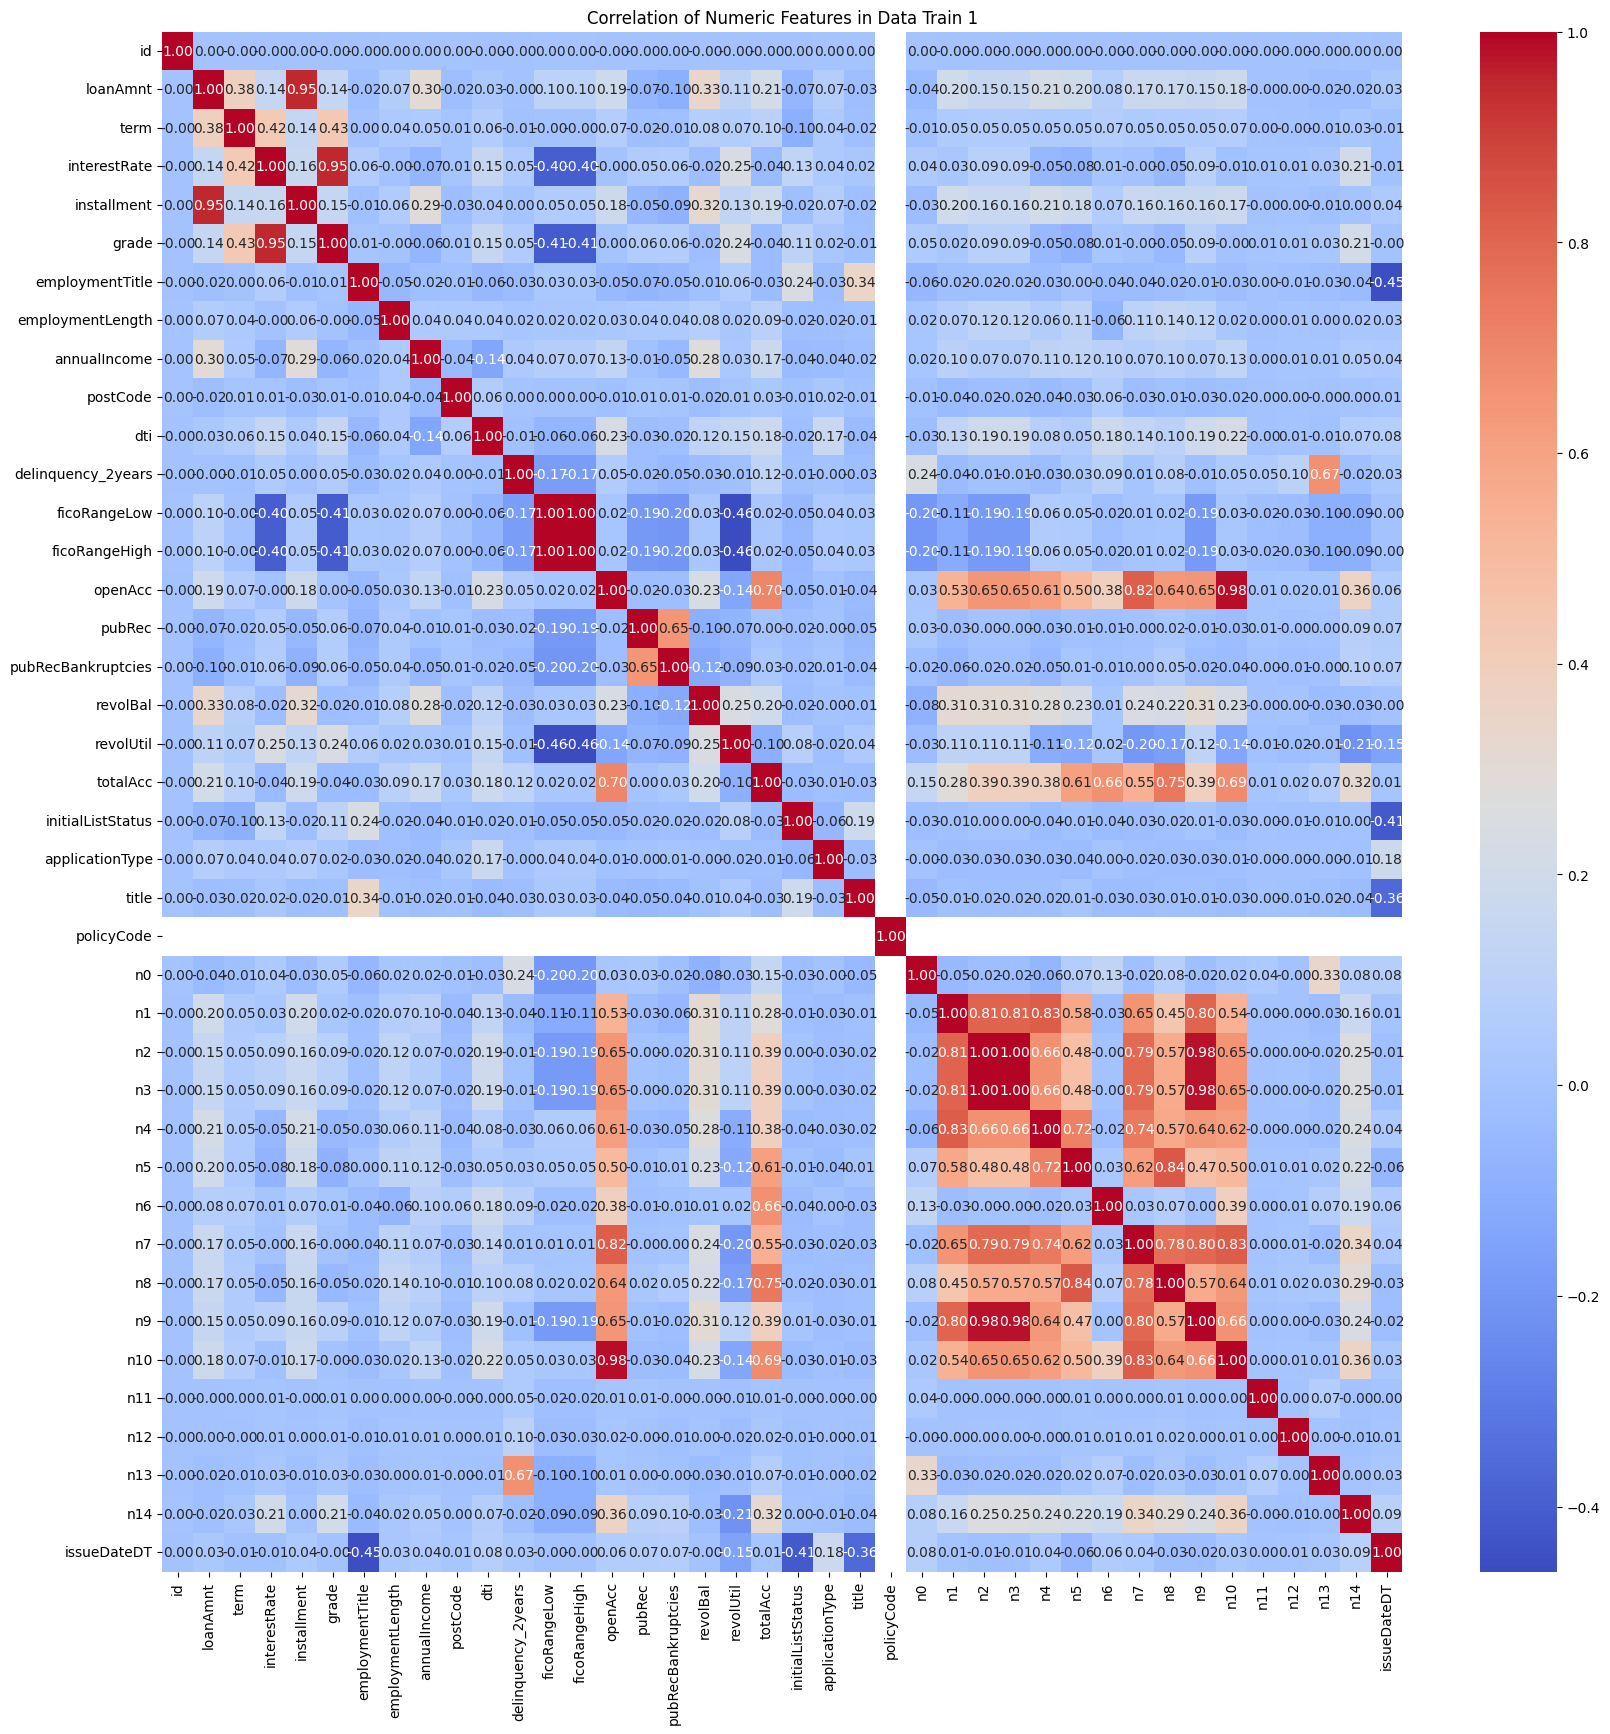

In [29]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

numeric_features = [t[0] for t in data_train1.dtypes if t[1] in ['int', 'double', 'float'] and t[0] != 'isDefault']

assembler = VectorAssembler(inputCols=numeric_features, outputCol="features")
assembled_data = assembler.transform(data_train1)

correlation_matrix = Correlation.corr(assembled_data, "features").head()[0]

correlation_pd = pd.DataFrame(correlation_matrix.toArray())
correlation_pd.index = numeric_features
correlation_pd.columns = numeric_features

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_pd, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation of Numeric Features in Data Train 1')
plt.show()


In [30]:
## logistic regression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

features = [col for col in data_train1.columns if col != 'isDefault' and col != 'id']
assembler = VectorAssembler(inputCols=features, outputCol="features")

lr = LogisticRegression(featuresCol="features", labelCol="isDefault", maxIter=10, regParam=0.0, elasticNetParam=0)

# Split the data into training set and test set
train_data, test_data = data_train1.randomSplit([0.7, 0.3], seed=42)

#Pipeline
pipeline = Pipeline(stages=[assembler, lr])

# training model
model = pipeline.fit(train_data)

# prediction
predictions = model.transform(test_data)

# evaluate
evaluator = BinaryClassificationEvaluator(labelCol="isDefault")
roc_auc = evaluator.evaluate(predictions)

# print ROC AUC
print(f"ROC AUC: {roc_auc}")

# confusion matrix
tp = predictions[(predictions.isDefault == 1) & (predictions.prediction == 1)].count()
tn = predictions[(predictions.isDefault == 0) & (predictions.prediction == 0)].count()
fp = predictions[(predictions.isDefault == 0) & (predictions.prediction == 1)].count()
fn = predictions[(predictions.isDefault == 1) & (predictions.prediction == 0)].count()

print("Confusion Matrix:")
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

# classification report
multi_evaluator = MulticlassClassificationEvaluator(labelCol="isDefault", predictionCol="prediction")
f1 = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})

print("Classification Report:")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Return model and prediction results for further operation
(predictions, model)


ROC AUC: 0.7043889195815655
Confusion Matrix:
True Positives: 915
True Negatives: 46289
False Positives: 903
False Negatives: 10961
Classification Report:
F1 Score: 0.7350564812310932
Precision: 0.7471707941050456
Recall: 0.7991467461231123


(DataFrame[id: int, loanAmnt: double, term: int, interestRate: double, installment: double, grade: int, employmentTitle: double, employmentLength: float, annualIncome: double, isDefault: int, postCode: double, dti: double, delinquency_2years: double, ficoRangeLow: double, ficoRangeHigh: double, openAcc: double, pubRec: double, pubRecBankruptcies: double, revolBal: double, revolUtil: double, totalAcc: double, initialListStatus: int, applicationType: int, title: double, policyCode: double, n0: double, n1: double, n2: double, n3: double, n4: double, n5: double, n6: double, n7: double, n8: double, n9: double, n10: double, n11: double, n12: double, n13: double, n14: double, issueDateDT: int, features: vector, rawPrediction: vector, probability: vector, prediction: double],
 PipelineModel_841c59e7dcd9)

In [31]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

numeric_features = [t[0] for t in data_train1.dtypes if t[1] in ['int', 'double', 'float']]
assembler = VectorAssembler(inputCols=numeric_features, outputCol="features")

train_data = assembler.transform(data_train1)

lr = LogisticRegression(labelCol="isDefault", featuresCol="features")

# set the param grid
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
                               .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
                               .build()

# evaluator
evaluator = BinaryClassificationEvaluator(labelCol="isDefault")

# cross-validation
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # 5-fold

cvModel = crossval.fit(train_data)

bestModel = cvModel.bestModel
print("Best model params:", bestModel.extractParamMap())



Best model params: {Param(parent='LogisticRegression_bea2baf4ed78', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LogisticRegression_bea2baf4ed78', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 1.0, Param(parent='LogisticRegression_bea2baf4ed78', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto', Param(parent='LogisticRegression_bea2baf4ed78', name='featuresCol', doc='features column name.'): 'features', Param(parent='LogisticRegression_bea2baf4ed78', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LogisticRegression_bea2baf4ed78', name='labelCol', doc='label column name.'): 'isDefault', Param(parent='LogisticRegression_bea2baf4ed78', name='maxBlockSizeInMB', doc='maximum m

In [32]:
param_map = bestModel.extractParamMap()

for param, value in param_map.items():
    print(f"{param.name}: {value}")


aggregationDepth: 2
elasticNetParam: 1.0
family: auto
featuresCol: features
fitIntercept: True
labelCol: isDefault
maxBlockSizeInMB: 0.0
maxIter: 100
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
regParam: 0.01
standardization: True
threshold: 0.5
tol: 1e-06


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ...........eta=0.1, max_depth=4, min_child_weight=1; total time=   3.0s
[CV] END ...........eta=0.1, max_depth=4, min_child_weight=1; total time=   4.5s
[CV] END ...........eta=0.1, max_depth=4, min_child_weight=1; total time=   6.3s
[CV] END ...........eta=0.1, max_depth=4, min_child_weight=1; total time=   3.8s
[CV] END ...........eta=0.1, max_depth=4, min_child_weight=1; total time=   3.5s
[CV] END ...........eta=0.1, max_depth=4, min_child_weight=5; total time=  13.4s
[CV] END ...........eta=0.1, max_depth=4, min_child_weight=5; total time=   8.2s
[CV] END ...........eta=0.1, max_depth=4, min_child_weight=5; total time=   3.0s
[CV] END ...........eta=0.1, max_depth=4, min_child_weight=5; total time=   3.0s
[CV] END ...........eta=0.1, max_depth=4, min_child_weight=5; total time=   4.1s
[CV] END ..........eta=0.1, max_depth=4, min_child_weight=10; total time=   5.0s
[CV] END ..........eta=0.1, max_depth=4, min_ch

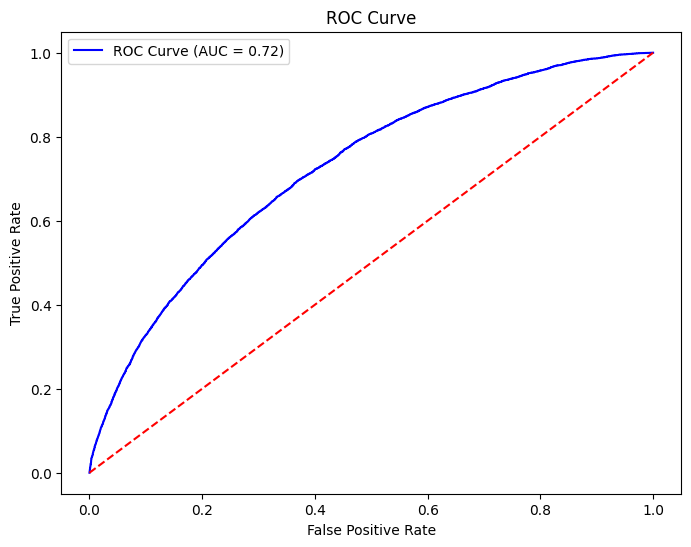

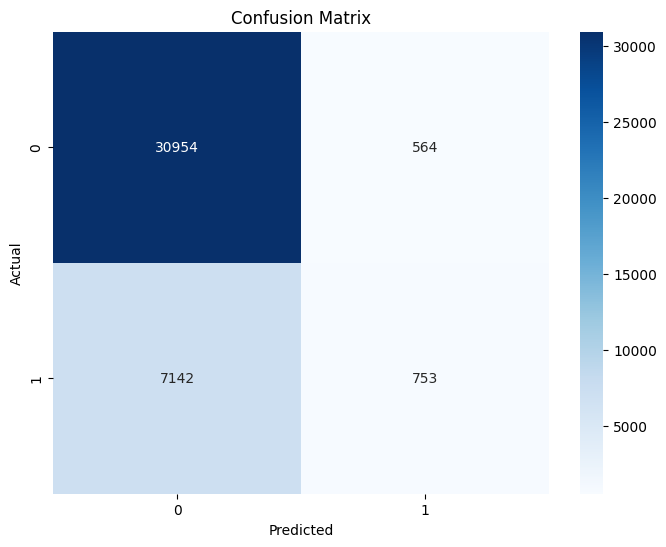

In [72]:
###############啊啊啊啊啊啊啊啊
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data_train1 is already a Pandas DataFrame
# Define features and target
data_train2 = data_train2.toPandas() if hasattr(data_train2, 'toPandas') else data_train2
X = data_train2.drop(columns=['isDefault'])  # Drop target and id columns
y = data_train2['isDefault']

# Define the XGBoost classifier
xgb = XGBClassifier(
    objective='binary:logistic',
    missing=np.nan,
    eval_metric='logloss',
    use_label_encoder=False
)

# Set up the parameter grid for cross-validation
param_grid = {
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 5, 10],
    'eta': [0.1, 0.01, 0.001]
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=2)

# Fit the model
grid_search.fit(X, y)

# Get the best model
best_model = grid_search.best_estimator_

# Print best model parameters
print("Best model params:", grid_search.best_params_)

# Initialize cross-validation
kf = StratifiedKFold(n_splits=5)
auc_scores = []
confusion_matrices = []

# Perform cross-validation and collect metrics
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    # Calculate AUC
    auc = roc_auc_score(y_test, y_proba)
    auc_scores.append(auc)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)

    print(f"Fold AUC: {auc}")
    print(f"Fold Confusion Matrix:\n{cm}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

# Calculate average AUC
avg_auc = np.mean(auc_scores)
print(f"Average AUC: {avg_auc}")

# Plot ROC curve for the last fold
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot confusion matrix for the last fold
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ................colsample_bytree=0.6, subsample=0.6; total time=   2.7s
[CV] END ................colsample_bytree=0.6, subsample=0.6; total time=   2.5s
[CV] END ................colsample_bytree=0.6, subsample=0.6; total time=   2.8s
[CV] END ................colsample_bytree=0.6, subsample=0.6; total time=   5.5s
[CV] END ................colsample_bytree=0.6, subsample=0.6; total time=   2.4s
[CV] END ................colsample_bytree=0.6, subsample=0.7; total time=   2.5s
[CV] END ................colsample_bytree=0.6, subsample=0.7; total time=   2.5s
[CV] END ................colsample_bytree=0.6, subsample=0.7; total time=   5.4s
[CV] END ................colsample_bytree=0.6, subsample=0.7; total time=   2.9s
[CV] END ................colsample_bytree=0.6, subsample=0.7; total time=   2.5s
[CV] END ................colsample_bytree=0.6, subsample=0.8; total time=   2.4s
[CV] END ................colsample_bytree=0.6, s

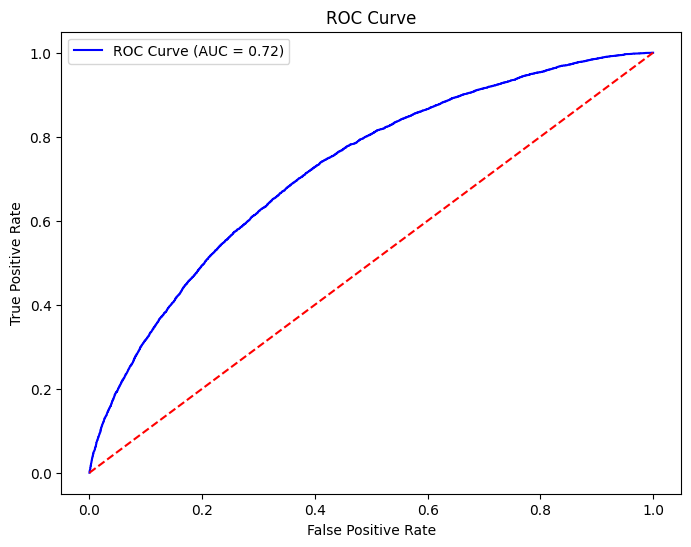

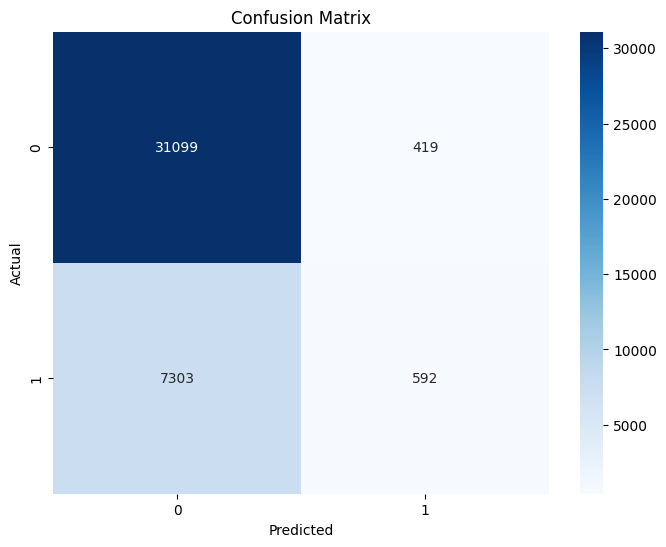

In [78]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data_train1 is already a Pandas DataFrame
# Define features and target
data_train2 = data_train2.toPandas() if hasattr(data_train2, 'toPandas') else data_train2
X = data_train2.drop(['isDefault'],axis = 1)  # Drop target and id columns
y = data_train2['isDefault']

# Define the other parameters
other_params = {'learning_rate': 0.1, 'n_estimators': 50, 'max_depth': 6, 'min_child_weight': 5, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

# Define the parameter grid for subsample and colsample_bytree
param_test = {
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
}

# Initialize the XGBoost classifier
xgb = XGBClassifier(**other_params)

# Set up the grid search with cross-validation
gs = GridSearchCV(estimator=xgb, param_grid=param_test, scoring='roc_auc', cv=5, n_jobs=1, verbose=2)

# Perform grid search and fit the model
best_model = gs.fit(X, y)

# Print best model parameters and score
print('Optimal parameters：', best_model.best_params_)
print('Best model score：', best_model.best_score_)

# Perform cross-validation and collect metrics
kf = StratifiedKFold(n_splits=5)
auc_scores = []
confusion_matrices = []

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    # Calculate AUC
    auc = roc_auc_score(y_test, y_proba)
    auc_scores.append(auc)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)

    print(f"Fold AUC: {auc}")
    print(f"Fold Confusion Matrix:\n{cm}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

# Calculate average AUC
avg_auc = np.mean(auc_scores)
print(f"Average AUC: {avg_auc}")

# Plot ROC curve for the last fold
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot confusion matrix for the last fold
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Fitting 5 folds for each of 27 candidates, totalling 135 fits
ROC AUC: 0.6994394229642469
Confusion Matrix:
[[46142  1152]
 [10704  1123]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89     47294
           1       0.49      0.09      0.16     11827

    accuracy                           0.80     59121
   macro avg       0.65      0.54      0.52     59121
weighted avg       0.75      0.80      0.74     59121



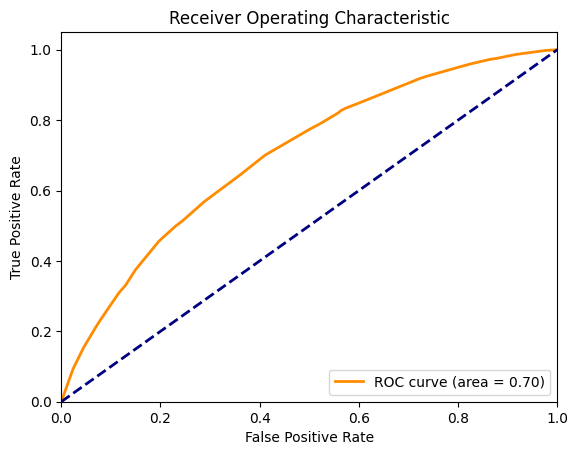

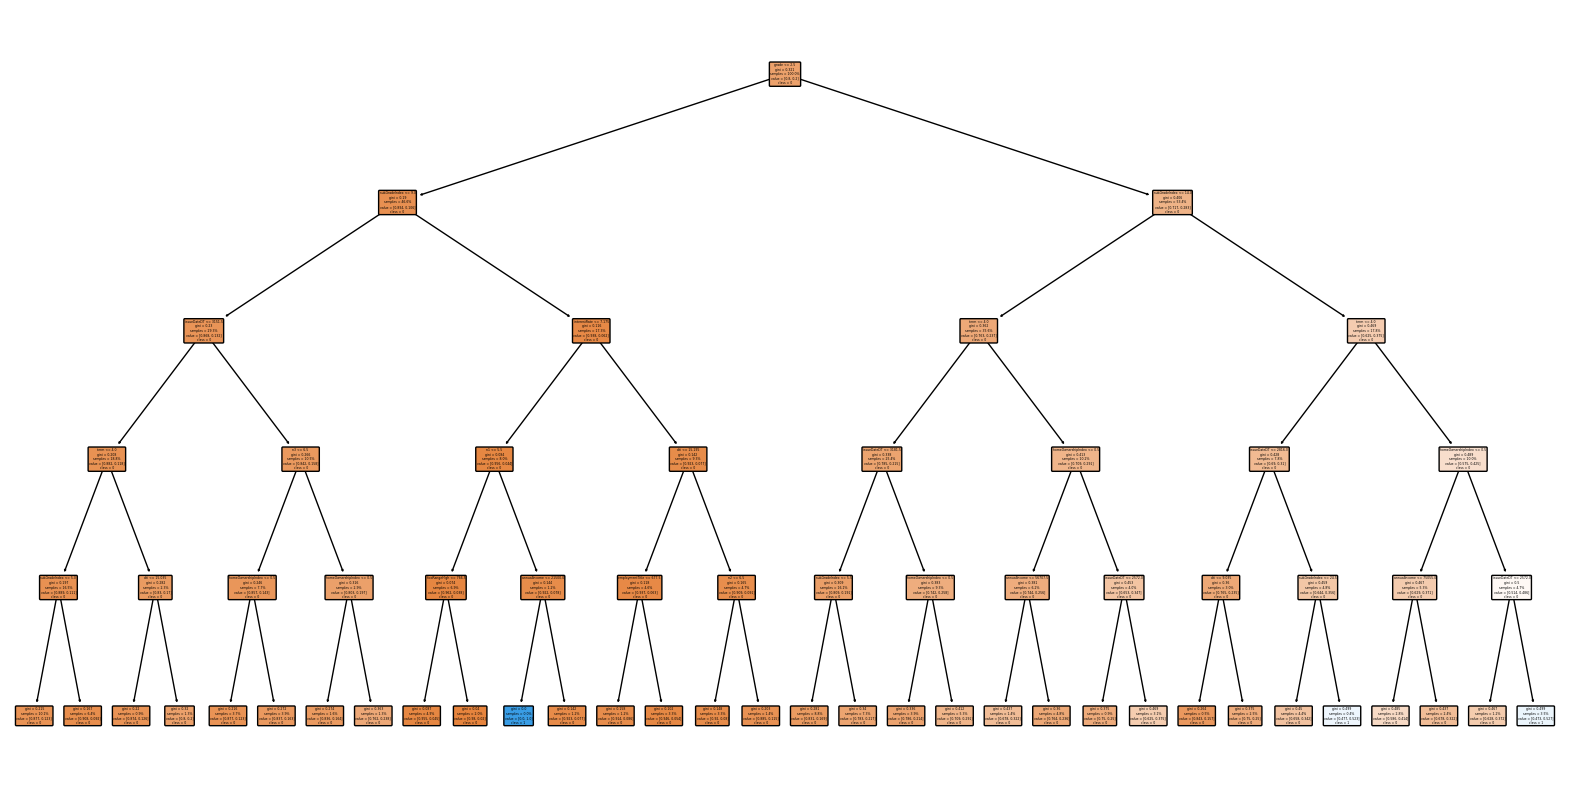

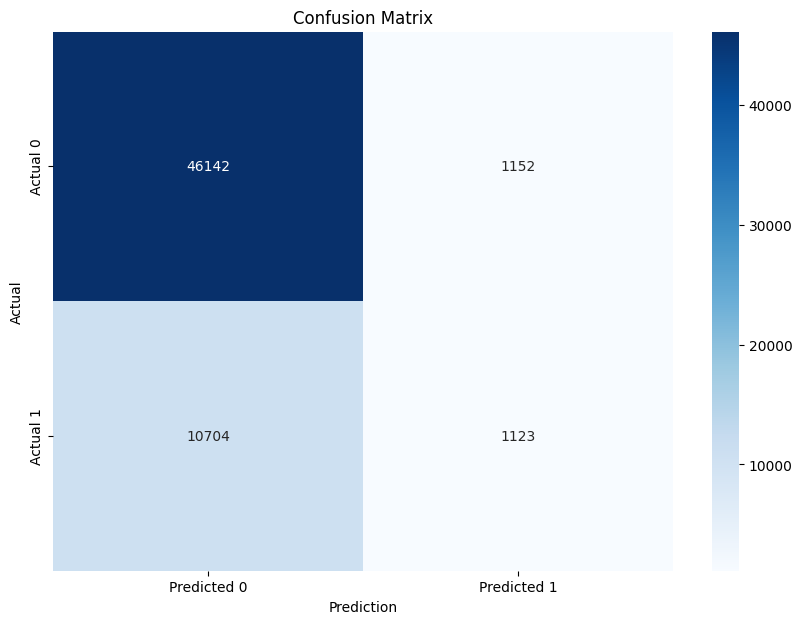

In [79]:
# import necessary libraries
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Assume data_train2 is a Pandas DataFrame
# Ensure data_train2 is in the correct format
data_train2 = data_train2.toPandas() if hasattr(data_train2, 'toPandas') else data_train2

# Define features and target
X = data_train2.drop(columns=['isDefault'])
y = data_train2['isDefault']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Set up the parameter grid
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Perform prediction
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC: {roc_auc}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_value = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_value)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_model, filled=True, feature_names=X.columns, class_names=['0', '1'], rounded=True, proportion=True)
plt.show()

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()